In [1]:
#Get data out from matlab file
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
mat = io.loadmat("FSU003.mat")

In [2]:
sf = round(1/abs(mat['FSU003'][0,0] - mat['FSU003'][1,0]))
dur_sec = np.size(mat['FSU003'][:,0])/sf
time = mat['FSU003'][:,0].T
MEA_channel_raw_read = mat['FSU003'][:,1:17].T

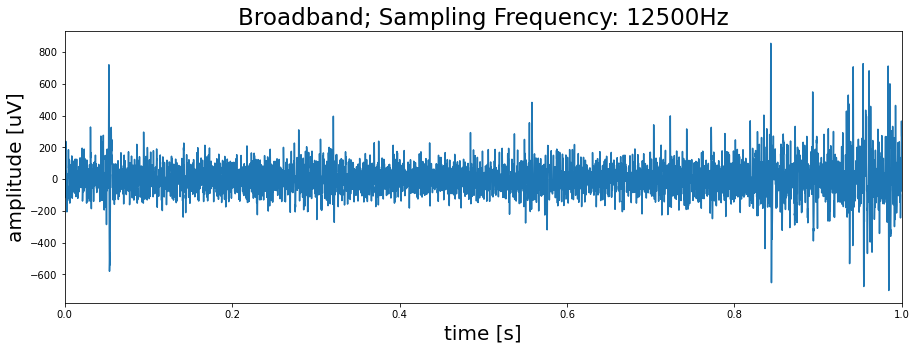

In [3]:
#Show one channel Data as a preview
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time[0:sf], MEA_channel_raw_read[11,0:sf])
ax.set_title('Broadband; Sampling Frequency: {}Hz'.format(sf), fontsize=23)
ax.set_xlim(0, time[sf])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
plt.show()

In [4]:
df = pd.DataFrame(MEA_channel_raw_read)

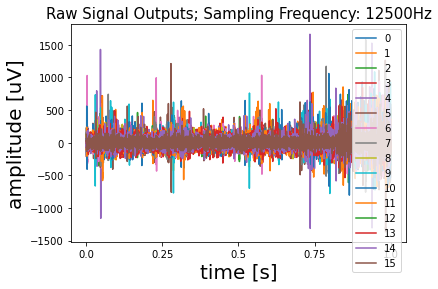

In [166]:
slice = df.iloc[:,:sf]
slice.T.plot()
plt.title('Raw Signal Outputs; Sampling Frequency: {}Hz'.format(sf), fontsize=15)
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
plt.xticks(np.linspace(0,sf,5),labels = np.linspace(0,1,5))
plt.savefig('raw.png', dpi = 300,bbox_inches='tight')

In [37]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [5]:
from scipy import signal
b,a = signal.butter(8,[0.016,0.24],'bandpass')
filtered_signal = signal.filtfilt(b,a,df)

In [17]:
pd.DataFrame(filtered_signal).plot()
plt.show()

: 

: 

In [14]:
np.median(abs(filtered_signal))

44.70506797770253

In [10]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=500):
    
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0] 
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:min(i+spike_window*2,data.shape[0])]
            
            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i
                
                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
    print(spike_samp)|
    
    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind.astype(int)]
    wave_form = wave_form[ind]
    
    return spike_samp, wave_form

In [190]:
from scipy import stats
start = 122
end = 124
spike_matrix = []
n_spikes = []
fire_rate_shape = []
fire_rate_max = []
fire_rate_kde = []
fire_rate_kde_max = []
#define bins 
binsize = 0.005*sf #seconds
bins= np.arange(0, sf*2+binsize, binsize)

for channel in range(16):
    spike_samp, wave_form = get_spikes(filtered_signal[channel,sf*start:sf*end].ravel(), spike_window=100, tf=4, offset=10,max_thresh = 3000)
    n_spikes.append(len(spike_samp))
    firing_rate_histogram = np.histogram(spike_samp, bins=bins)
    firing_rate = firing_rate_histogram[0] #conversion to hertz
    # firing_rate_histogram = (firing_rate,firing_rate_histogram[1])
    analytic_signal = hilbert(firing_rate)
    fire_rate_shape.append(analytic_signal)
    kernel = stats.gaussian_kde(spike_samp)
    Z = np.reshape(kernel(spike_samp).T, spike_samp.shape)
    fire_rate_kde.append(Z)
    fire_rate_kde_max.append(Z.max())
    fire_rate_max.append(max(firing_rate))
    spike_matrix.append(spike_samp)

# print(n_spikes)
    

[ 1779.  1780.  7853.  7853.  7854.  9236.  9597.  9597.  9598. 10354.
 10354. 10354. 10354. 10354. 10354. 10354. 10354. 10354. 10355. 10356.
 10434. 10434. 10720. 10720. 10720. 10721. 10935. 10935. 10936. 11169.
 11169. 11169. 11169. 11169. 11169. 11169. 11170. 11250. 11250. 11251.
 11277. 11278. 11754. 11754. 11754. 11754. 11754. 11755. 12001. 12001.
 12001. 12002. 12296. 12296. 12296. 12296. 12296. 12296. 12296. 12296.
 12296. 12296. 12296. 12296. 12296. 12296. 12296. 12297. 12324. 12324.
 12324. 12324. 12325. 12373. 12548. 12548. 12548. 12548. 12548. 12548.
 12548. 12548. 12548. 12548. 12548. 12548. 12548. 12548. 12548. 12548.
 12548. 12548. 12548. 12548. 12548. 12548. 12549. 12550. 12653. 12653.
 12653. 12653. 12653. 12653. 12653. 12812. 12812. 12812. 12812. 12812.
 12812. 12812. 12812. 12812. 12927. 12927. 12927. 12927. 12927. 12927.
 12927. 12927. 12927. 12927. 12927. 13018. 13018. 13018. 13018. 13018.
 13018. 13018. 13018. 13018. 13018. 13018. 13018. 13018. 13018. 13018.
 13018

/home/simon/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/tmp/ipykernel_6026/1626193266.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  firing_y = np.linspace(0,52*20,6).astype(np.int)
/tmp/ipykernel_6026/16261

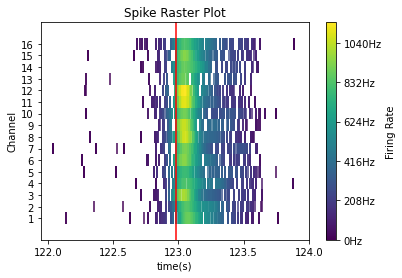

In [214]:
import matplotlib as mpl

norm = mpl.colors.Normalize(0, max(fire_rate_kde_max))
colors = [mpl.cm.viridis(norm(c)) for c in fire_rate_kde]


f, ax = plt.subplots()

spikes = ax.eventplot(np.asarray(spike_matrix),colors = colors)
spikes[0].set_norm(norm)
bar = f.colorbar(spikes[0])
firing_y = np.linspace(0,52*20,6).astype(np.int)
color_y = ['{}Hz'.format(y_label) for y_label in firing_y]
bar.ax.set_yticklabels(color_y)
bar.set_label("Firing Rate")

ax.title.set_text('Spike Raster Plot')
# ax.title('Spike Raster Plot')
plt.xlabel("time(s)")
plt.ylabel("Channel")
plt.axvline(12300,color='r')
plt.xticks(np.linspace(0,sf*2,5),labels = np.linspace(start,end,5))
plt.yticks(list(range(0,16)),labels= list(range(1,17)))

plt.savefig('raster.png', dpi = 300,bbox_inches='tight')


ConversionError: Failed to convert value(s) to axis units: ['0 Hz', '624 Hz', '1024 Hz']

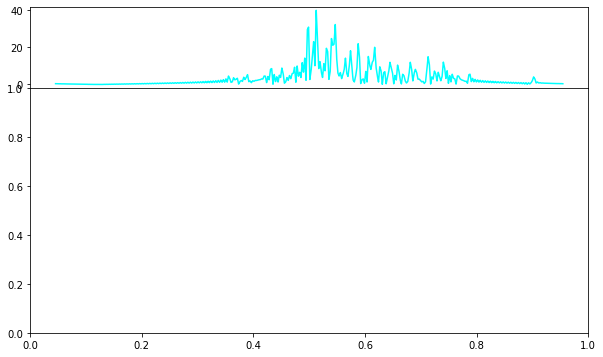

In [234]:
from scipy import interpolate

fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,3])
axs = gs.subplots(sharex=False, sharey=False)
x = firing_rate_histogram[1][:-1]
y = abs(analytic_signal)
f = interpolate.interp1d(x, y)
xnew = np.arange(0,24938)
ynew = f(xnew)
x_new = np.arange(0,2*sf)
y_new = np.hstack([ynew,np.zeros(2*sf-24938)])

axs[0].plot(xnew, ynew,color = "cyan",label = "Firing Rate")
axs[0].set_yticks([0,624,1024])
axs[1].eventplot(np.asarray(spike_matrix))
plt.xlim(0,2*sf)

axs[0].axvline(12250,color='r',label = "FUS Stimulation")
axs[1].axvline(12300,color='r')
plt.legend()
plt.show()

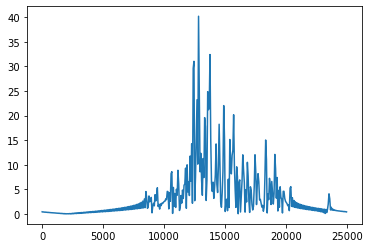

In [204]:
# import seaborn as sns
from scipy.signal import hilbert

binsize = 0.005*sf #seconds
# bins = int(time / binsize)+1
bins= np.arange(0, sf*2+binsize, binsize)

sp_indicator = np.zeros(abs(sf*start-sf*end))
sp_indicator[spike_samp.astype(np.int64).tolist()] = 10

# make a histogram 

firing_rate_histogram = np.histogram(spike_samp, bins=bins)
firing_rate = firing_rate_histogram[0] #conversion to hertz
# firing_rate_histogram = (firing_rate,firing_rate_histogram[1])
analytic_signal = hilbert(firing_rate)

# bins = int((sf*2+binsize) / binsize)+1

plt.plot(firing_rate_histogram[1][:-1],abs(analytic_signal)*)

plt.show()
# sns.histplot(spike_samp,bins = bins,element="poly")

In [224]:
np.arange(0,24937)

array([    0,     1,     2, ..., 24934, 24935, 24936])

In [44]:
np.asarray(spike_matrix).shape

/home/simon/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(16,)

[6.6200000e+02 6.9790000e+03 1.0548000e+04 ... 1.4554203e+07 1.4554204e+07
 1.4554205e+07]


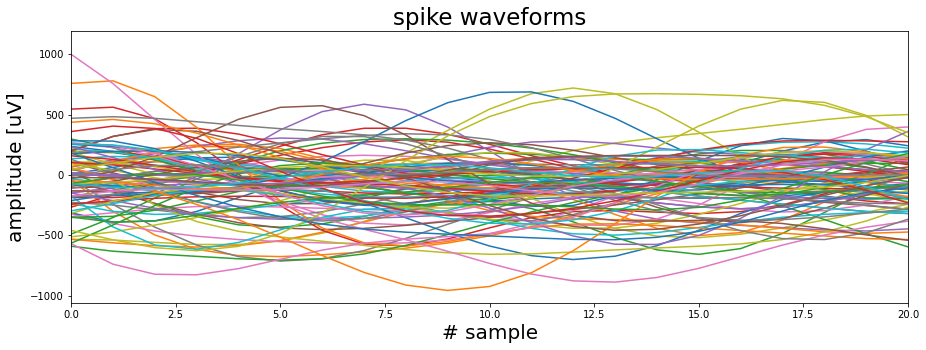

In [30]:
spike_samp, wave_form = get_spikes(filtered_signal[11,:].ravel(), spike_window=50, tf=5, offset=20)

np.random.seed(10)
fig, ax = plt.subplots(figsize=(15, 5))

for i in range(100):
    spike = np.random.randint(0, wave_form.shape[0])
    ax.plot(wave_form[spike, :])

ax.set_xlim([0, 20])
ax.set_xlabel('# sample', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)
ax.set_title('spike waveforms', fontsize=23)
plt.show()

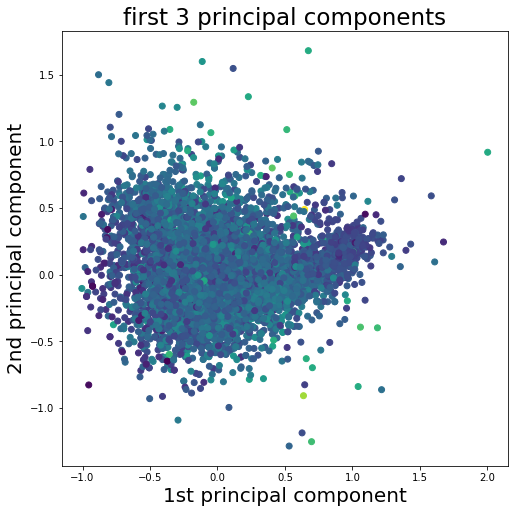

In [9]:
import sklearn as sk
from sklearn.decomposition import PCA

# Apply min-max scaling
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wave_form)

# Do PCA
pca = PCA(n_components=15)
pca_result = pca.fit_transform(dataset_scaled)

# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

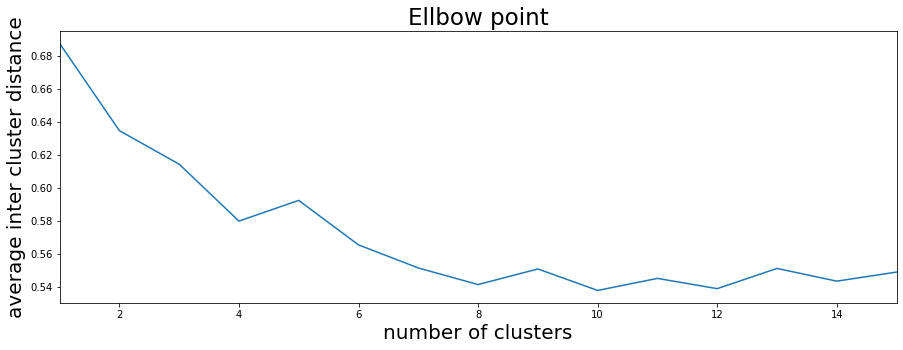

In [10]:
def k_means(data, num_clus=3, steps=200):

    # Convert data to Numpy array
    cluster_data = np.array(data)
    
    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))
            
            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):    
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())
            
    return cluster, center_init, distance
    
max_num_clusters = 15

average_distance = []
for run in range(20):
    tmp_average_distance = []
    for num_clus in range(1, max_num_clusters +1):
        cluster, centers, distance = k_means(pca_result, num_clus)
        tmp_average_distance.append(np.mean([np.mean(distance[x][cluster==x]) for x in range(num_clus)], axis=0))
    average_distance.append(tmp_average_distance)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(1, max_num_clusters +1), np.mean(average_distance, axis=0))
ax.set_xlim([1, max_num_clusters])
ax.set_xlabel('number of clusters', fontsize=20)
ax.set_ylabel('average inter cluster distance', fontsize=20)
ax.set_title('Ellbow point', fontsize=23)
plt.show()


In [21]:
from sklearn.manifold import TSNE
from numpy.random import RandomState
rng = RandomState(0)

t_sne = TSNE(
    n_components=3,
    perplexity=20,
    n_iter=250,
    init="random",
    random_state=rng,
)
S_t_sne = t_sne.fit_transform(dataset_scaled)
# X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3).fit_transform(dataset_scaled)

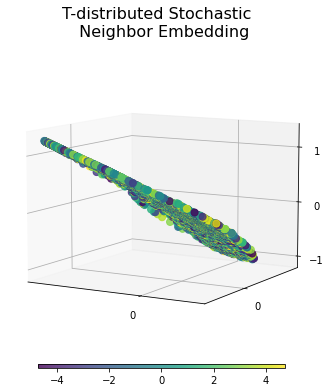

In [24]:
from matplotlib import ticker
from sklearn import manifold, datasets
%matplotlib inline

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

S_points, S_color = datasets.make_s_curve(8189, random_state=rng)
plot_3d(S_t_sne, S_color, "T-distributed Stochastic  \n Neighbor Embedding")
plt.show()


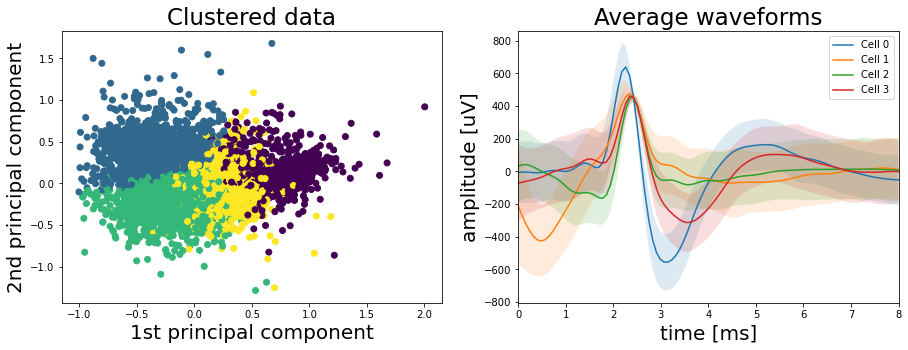

In [95]:
num_clus = 4
cluster, centers, distance = k_means(pca_result, num_clus)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('Clustered data', fontsize=23)

time = np.linspace(0, wave_form.shape[1]/sf, wave_form.shape[1])*1000
for i in range(num_clus):
    cluster_mean = wave_form[cluster==i, :].mean(axis=0)
    cluster_std = wave_form[cluster==i, :].std(axis=0)
    
    ax[1].plot(time, cluster_mean, label='Cell {}'.format(i))
    ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

ax[1].set_title('Average waveforms', fontsize=23)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.savefig('spikesort.png', dpi = 300)
plt.show()



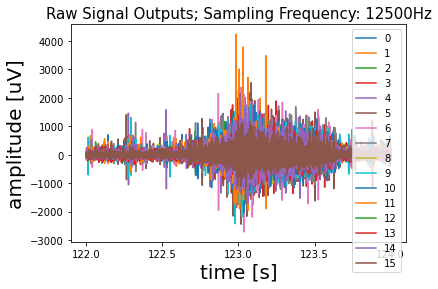

In [49]:
start = 122
end = 124
slice = df.iloc[:,sf*start:sf*end]
slice.T.plot()
plt.title('Raw Signal Outputs; Sampling Frequency: {}Hz'.format(sf), fontsize=15)
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
plt.xticks(np.linspace(sf*start,sf*end,5),labels = np.linspace(start,end,5))
plt.savefig('raw.png', dpi = 300,bbox_inches = 'tight')

In [51]:
sigma_n = np.median(abs(filtered_signal_slice)) / 0.6745
# print(sigma_n)
threshold = 5 * sigma_n
threshold

458.54450973457847

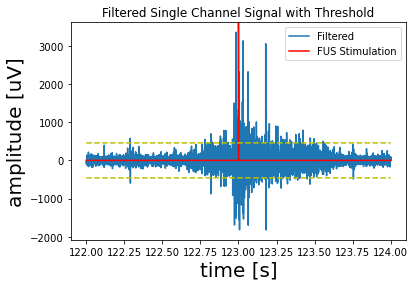

In [230]:

filtered_signal_slice = signal.filtfilt(b,a,slice)

t = time[sf*start:sf*end]
def filtered_dataplot():
    plt.plot(t, filtered_signal_slice[11,:],label='Filtered')
    plt.title("Filtered Single Channel Signal with Threshold")
    plt.axis("tight")


st_ind = np.array([60+6 ,2*60+3, 3*60+13, 4*60+22, 5*60+38, 9*60+4, 10*60+5, 11*60+43, 12*60+16, 15*60, 16*60+14, 17*60+32])
st_ind = st_ind*sf

st_indicator = np.zeros(time.shape[0])
st_indicator[st_ind] = 4000
st_indicator_slice = st_indicator[sf*start:sf*end]

filtered_dataplot()
plt.plot(t,st_indicator_slice,c='r',label = "FUS Stimulation")
plt.plot(t, threshold * np.ones(len(t)), c="y", linestyle="--" )
plt.plot(t, -1*threshold * np.ones(len(t)), c="y", linestyle="--" )
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
plt.legend()
plt.savefig('filtered.png', dpi = 300,bbox_inches='tight')



Text(0, 0.5, 'amplitude [uV]')

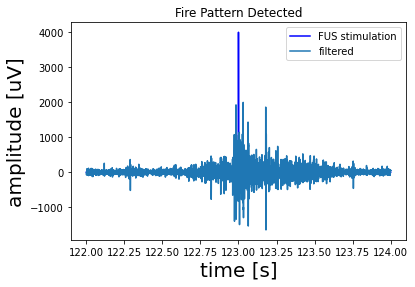

In [62]:
from scipy.ndimage.filters import gaussian_filter1d


single = filtered_signal_slice[11,:]
selected_filtered_single = gaussian_filter1d(single, sigma=3)
index = np.arange(len(single))

tMax_hard = index[abs(single)>threshold]#Hard Threshold
tMax = np.array(list(set(signal.argrelmax(selected_filtered_single)[0]).intersection(set(tMax_hard))))
tMin_hard = index[single<-threshold]#Hard Threshold
tMin = np.array(list(set(signal.argrelmin(selected_filtered_single)[0]).intersection(set(tMin_hard))))

# plt.plot(single, label = 'raw')
sp_indicator = np.zeros(time.shape[0])
# sp_indicator[spike_samp.astype(np.int64).tolist()] = 3000
# sp_indicator_slice = sp_indicator[sf*start:sf*end]

plt.title("Fire Pattern Detected")
plt.plot(t,st_indicator_slice,c='b',label = "FUS stimulation")

# plt.plot(t,sp_indicator_slice,c='y',label = "spike detected")

plt.plot(t,selected_filtered_single, label = 'filtered')
# plt.plot(tMax,selected_filtered_single[tMax], 'o', mfc= 'none', label = 'max')
# plt.plot(tMin,selected_filtered_single[tMin], 'o', mfc= 'none', label = 'min')
# plt.plot(t, threshold * np.ones(len(t)), c="r", linestyle="--" )
# plt.plot(t, -1*threshold * np.ones(len(t)), c="r", linestyle="--" )
# plt.xticks(np.linspace(sf*start,sf*end,5),labels = np.linspace(start,end,5))
plt.legend()
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('amplitude [uV]', fontsize=20)
# plt.savefig('filter_final.png', dpi = 300,bbox_inches='tight')

IndexError: tuple index out of range

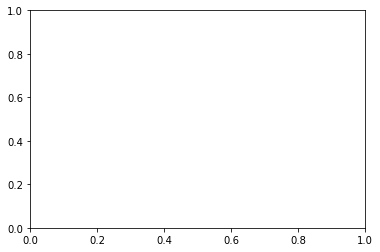

In [13]:
import librosa
import librosa.display
single = filtered_signal_slice[11,:]
selected_filtered_single = gaussian_filter1d(single, sigma=3)

fig, ax = plt.subplots()
img = librosa.display.specshow(selected_filtered_single, ax=ax)
fig.colorbar(img, ax=ax)
plt.show()

In [69]:
np.argwhere(st_indicator_slice>0)
# print(st_indicator_slice[0])

array([[12500]])

In [150]:
spike_samp.astype(np.int64)

array([     662,     6979,    10548, ..., 14552507, 14552868, 14553053])

In [134]:
time.shape

(14568750,)

In [160]:
sf*end

1550000

In [158]:
guai= list(set(spike_samp[spike_samp<sf*end].tolist()).intersection(set(spike_samp[spike_samp>sf*start].tolist())))
guai

[1536642.0,
 1541508.0,
 1542278.0,
 1542547.0,
 1544469.0,
 1534485.0,
 1534746.0,
 1540380.0,
 1541022.0,
 1543711.0,
 1541413.0,
 1533993.0,
 1546922.0,
 1539509.0,
 1541174.0,
 1540793.0,
 1544635.0,
 1536062.0,
 1538878.0,
 1542979.0,
 1535428.0,
 1540422.0,
 1538630.0,
 1539272.0,
 1540298.0,
 1542348.0,
 1544528.0,
 1539794.0,
 1541460.0,
 1540575.0,
 1539039.0,
 1541859.0,
 1536485.0,
 1534950.0,
 1535079.0,
 1543911.0,
 1541737.0,
 1543402.0,
 1539308.0,
 1535344.0,
 1537013.0,
 1540726.0,
 1543672.0]

In [106]:
# spike_samp[-1]
a = np.array([1,2,3,4])
a[[1,2]] = 0
a

array([1, 0, 0, 4])

In [88]:
spike_samp.shape

(8189,)

In [ ]:
tMin_hard

array([-553.81618814, -615.19470131, -617.29686189, ..., -710.02797613,
       -667.22673388, -604.84103601])

In [ ]:
index.shape

(1294,)

In [ ]:
a = np.array([1,2,5])
b = np.array(list(range(3)))
b[a>1]

array([1, 2])